In [1]:
import TFX_NASA_handler as TFX
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


In [2]:
dirPath = './archive/CMaps/'
handler = TFX.TFX_NASA_Handler('kerasregression_test',dirPath)
train, test, y_test = handler.load_data()
handler.data_prep( train, test )

Data Prep Complete, columns dropped and smoothing applied 


In [3]:
handler.X_train,handler.X_test = handler.zscore(handler.X_train,handler.X_test)

In [4]:
# apply PCA
from sklearn.decomposition import PCA
reduce_dim = 8

pca = PCA(n_components=reduce_dim)
pca.fit(handler.X_train)

print(pca.explained_variance_ratio_)
X_train = pca.transform(handler.X_train)
X_test = pca.transform(handler.X_test)

[0.71769606 0.14115369 0.06274844 0.0264292  0.00828486 0.00713111
 0.00656403 0.0053098 ]


In [5]:
img_rows, img_cols = 1, reduce_dim
input_shape = (img_rows, img_cols, 1)

In [6]:
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
# X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [7]:
model = tf.keras.models.Sequential()

In [8]:
model.add(tf.keras.layers.Conv2D(32, kernel_size=(1, 5),padding='same',               
                 input_shape=input_shape))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.Activation("relu"))
model.add(
        tf.keras.layers.Conv2D(
            filters=64, kernel_size=(1,3), strides=(1),name="c2",padding='same',
        ),)
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.Activation("relu"))
model.add(
        tf.keras.layers.Conv2D(
            filters=128, kernel_size=(1,3), strides=(1),name="c3",padding='same',
        ),)

model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.Activation("relu"))
model.add(
        tf.keras.layers.Conv2D(
            filters=128, kernel_size=(1,3), strides=(1),name="c4",padding='same',
        ),)

model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.Activation("relu"))



model.add(
        tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1,3), strides=(1),name="c5",padding='same',
        ),)
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=128))
model.add(tf.keras.layers.Dense(units=1))

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0005) # default is 0.001
model.compile(optimizer = opt, loss = 'mean_squared_error', metrics=['mean_squared_error', 'mae'])


In [10]:
history = model.fit(X_train, handler.y_train ,batch_size = 128, epochs = 30,verbose=1,
                   callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5,
                                                     verbose=0, mode='min')],
                  validation_split=0.2)

Epoch 1/30
129/129 [==============================] - 3s 17ms/step - loss: 4696.3936 - mean_squared_error: 4696.3936 - mae: 55.2917 - val_loss: 4569.8535 - val_mean_squared_error: 4569.8535 - val_mae: 57.2593
Epoch 2/30
129/129 [==============================] - 2s 15ms/step - loss: 387.5548 - mean_squared_error: 387.5548 - mae: 14.9430 - val_loss: 1398.6469 - val_mean_squared_error: 1398.6469 - val_mae: 30.2423
Epoch 3/30
129/129 [==============================] - 2s 15ms/step - loss: 340.3584 - mean_squared_error: 340.3584 - mae: 13.8954 - val_loss: 967.0474 - val_mean_squared_error: 967.0474 - val_mae: 24.3675
Epoch 4/30
129/129 [==============================] - 2s 15ms/step - loss: 307.0904 - mean_squared_error: 307.0904 - mae: 13.1287 - val_loss: 852.6836 - val_mean_squared_error: 852.6836 - val_mae: 22.3341
Epoch 5/30
129/129 [==============================] - 2s 15ms/step - loss: 280.7094 - mean_squared_error: 280.7094 - mae: 12.5278 - val_loss: 978.5819 - val_mean_squared_erro

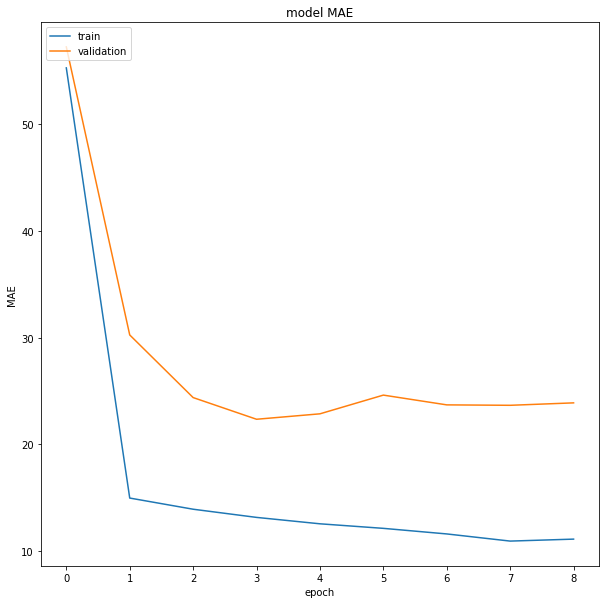

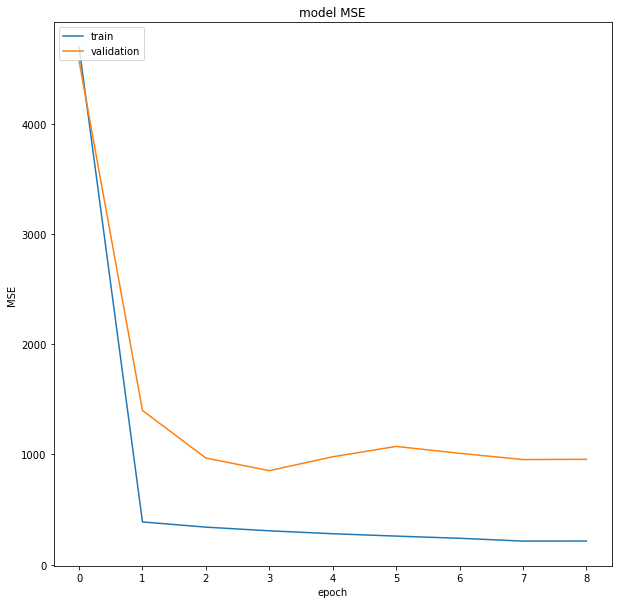

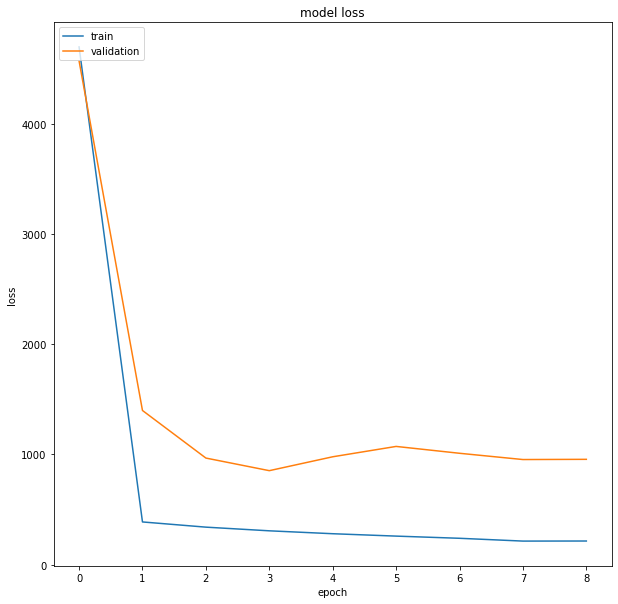

In [11]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

# summarize history for RMSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
fig_acc.savefig("model_rmse.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left') 
plt.show()
fig_acc.savefig("model_regression_loss.png")

In [12]:
model_pred = model.predict(X_test)

4/4 [==============================] - 0s 5ms/step


In [13]:
RMSE = np.sqrt(mean_squared_error(y_test,model_pred))
print("RMSE: ", RMSE)

RMSE:  23.993121932457573
R-squared: <function r2_score at 0x000001D8A8E018B0>


In [14]:
r2_score(y_test,model_pred)

0.6666396234748839